# Iterative GP

In [7]:
%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import numpy as np
import matplotlib.pyplot as plt

import GPy

# Theory

Most of the other notes assume that creating a GP has a few steps:
* Choose training points
* Evaluate the function we are trying to emulate at those points
* Do whatever it is we wanted to do (e.g. posterior inference) using the trained GP.

However, we often don't know where we need to get good training data before we have any. So, this process requires us to collect a large number of samples, many of which will be in really poor positions, to get enough samples in good locations.
An alternative is to first roughly approximate the function with a few samples. Then get more samples in the regions of interest (regions that have a high probability of being high probability). And repeat.

See:
* https://arxiv.org/pdf/1812.04631.pdf

# Example

Let's try work out the parameters to a simple quadratice function.

What I have here is horribly wrong. What I neded to do is start sampling in parameter (theta) space. Then predict the liklihood.

Actually this might not be true... Go back and read the paper!

In [68]:
theta = np.array([0.01, 0.1, -2, 3])
x_range = np.array([-10, 10])
noise = 0.1
train_samples = 5

In [69]:
f = lambda x: np.dot(theta, np.array([np.power(x, 3), np.power(x, 2), x, 1]))
x = np.linspace(x_range[0], x_range[1], num=100)

## Initial GP training

Initially we train the GP just as normal.

In [70]:
train_x = np.random.random(size = train_samples-2) * (x_range[1] - x_range[0]) + x_range[0]
train_x = np.append(train_x, x_range)
train_y  = f(train_x) + np.random.normal(0, noise, size=train_samples)

In [73]:
k = GPy.kern.RBF(1)
m = GPy.models.GPRegression(train_x[:,np.newaxis], train_y[:,np.newaxis], k)

m.Gaussian_noise.constrain_fixed(noise)
m.optimize(messages=True)

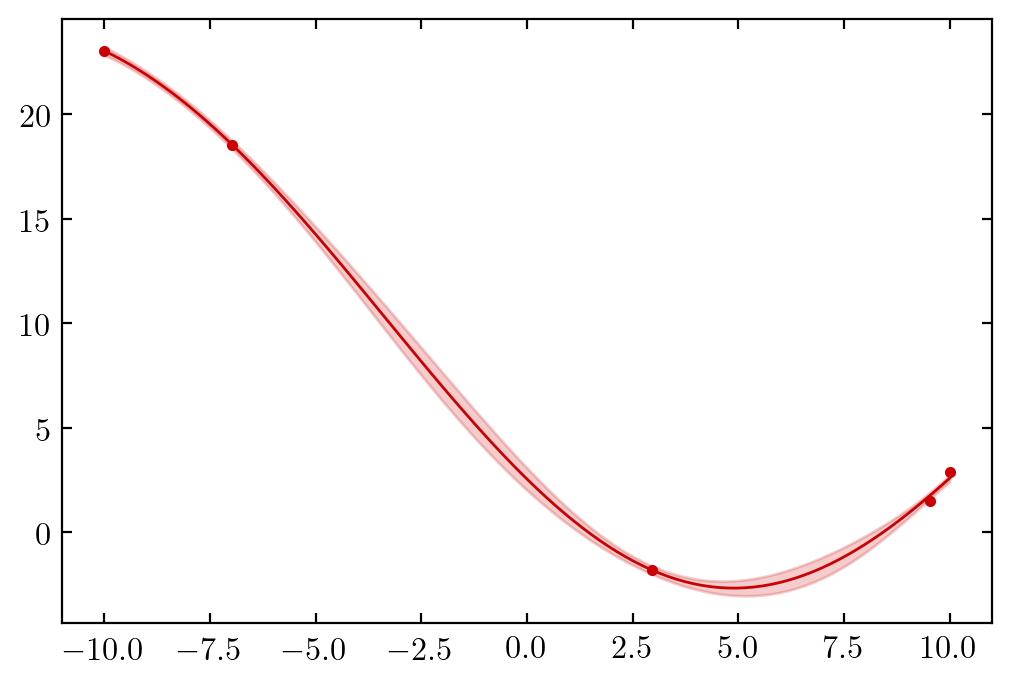

In [74]:
val, err = m.predict(x[:,np.newaxis])
val, err = val.flatten(), err.flatten()

_, ax = plt.subplots()
ax.scatter(train_x, train_y, label="training")
l = ax.plot(x, val, label="prediction")
ax.fill_between(x, val-err, val+err, alpha=0.2, color=l[0].get_color())

## Iterative update

We can now focus on regions of high probability and get more samples there.